Segmentation of different tissues from MRI scans of the brain is an important step for further downstream applications such as disease prediction, classification or brain age estimation.

The goal of the coursework is to implement classical and deep learning approaches for segmentation of different tissue types in MRI scans of the brain, i.e., background, cerebrospinal fluid (CSF), white matter (WM), and gray matter (GM). We provide data from a total of 652 healthy subjects, that is split into different development sets and a hold-out test set on which you will evaluate your final segmentation accuracy.
Each approach will require a processing pipeline with different components that you will need to implement using methods that were discussed in the lectures and tutorials. There are three dedicated parts in the Jupyter notebook for each approach which contain some detailed instructions and some helper code.

**Make sure to select the correct runtime when working in Google Colab (GPU)**

## Downloading the Data

In [1]:
! wget -q --show-progress https://www.dropbox.com/s/w9njau9t6rrheel/brainage-data.zip
! unzip -qq -o brainage-data.zip
! wget -q --show-progress https://www.dropbox.com/s/f5mt8p9pkszff3x/brainage-testdata.zip
! unzip -qq -o brainage-testdata.zip


brainage-data.zip.2 100%[===================>] 446.94M  64.6MB/s    in 7.5s    
brainage-testdata.z 100%[===================>]   1.49K  --.-KB/s    in 0s      


## Imports

In [2]:
import os
import glob
import random
from argparse import Namespace
from functools import partial
from multiprocessing import Pool
from numbers import Number
from typing import Any, Dict
from typing import List, Tuple

import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm


def seed_everything(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False


def mean_absolute_error(preds: Tensor, targets: Tensor) -> float:
    """Compute the mean absolute error between predictions and targets"""
    return (preds.view(-1) - targets.view(-1)).abs().mean().item()


class TensorboardLogger(SummaryWriter):
    def __init__(
        self,
        log_dir: str = None,
        config: Namespace = None,
        enabled: bool = True,
        comment: str = '',
        purge_step: int = None,
        max_queue: int = 10,
        flush_secs: int = 120,
        filename_suffix: str = ''
    ):
        self.enabled = enabled
        if self.enabled:
            super().__init__(
                log_dir=log_dir,
                comment=comment,
                purge_step=purge_step,
                max_queue=max_queue,
                flush_secs=flush_secs,
                filename_suffix=filename_suffix
            )
        else:
            return

        # Add config
        if config is not None:
            self.add_hparams(
                {k: v for k, v in vars(config).items() if isinstance(
                    v, (int, float, str, bool, torch.Tensor))},
                {}
            )

    def log(self, data: Dict[str, Any], step: int) -> None:
        """Log each entry in data as its corresponding data type"""
        if self.enabled:
            for k, v in data.items():
                # Scalars
                if isinstance(v, Number):
                    self.add_scalar(k, v, step)

                # Images
                elif (isinstance(v, np.ndarray) or isinstance(v, torch.Tensor)) and len(v.shape) >= 3:
                    if len(v.shape) == 3:
                        self.add_image(k, v, step)
                    elif len(v.shape) == 4:
                        self.add_images(k, v, step)
                    else:
                        raise ValueError(f'Unsupported image shape: {v.shape}')

                # Matplotlib figures
                elif isinstance(v, plt.Figure):
                    self.add_figure(k, v, step)

                else:
                    raise ValueError(f'Unsupported data type: {type(v)}')


def load_nii(path: str, dtype: str = 'float32') -> np.ndarray:
    """Load an MRI scan from disk and convert it to a given datatype

    :param path: Path to file
    :param dtype: Target dtype
    :return img: Loaded image. Shape (H, W, D)
    """
    return nib.load(path).get_fdata().astype(np.dtype(dtype))


def load_segmentations(paths: str):
    """Load all segmentations and associated subject_ids"""
    filenames, segmentations = [], []
    for im in tqdm(paths):
        id = im.split('_brain_')[0].split('/')[-1].split('-')[1].split('_')[0]
        segmentations.append(load_nii(im))
        filenames.append(id)
    return filenames, np.array(segmentations)


def plot_segmentations(im: np.ndarray, seg: np.ndarray, i: int = 65, title: str = None):
    fig, ax = plt.subplots(2, 3, figsize=(20, 10))

    col = 2
    ax[0, col].imshow(np.rot90(im[..., i], k=3), cmap='gray')
    ax[0, col].imshow(np.rot90(seg[..., i], k=3),
                 alpha=0.5 * (np.rot90(seg[..., i] > 0, k=3)),
                 interpolation=None, cmap='jet')
    ax[1, col].imshow(np.rot90(im[..., i], k=3), cmap='gray')
    ax[0, col].set_title('Axial')

    k = 1
    col = 0
    ax[0, col].imshow(np.rot90(im[i, ...], k=k), cmap='gray')
    ax[0, col].imshow(np.rot90(seg[i, ...], k=k),
                 alpha=0.5 * (np.rot90(seg[i, ...] > 0, k=k)),
                 interpolation=None, cmap='jet')
    ax[1, col].imshow(np.rot90(im[i, ...], k=k), cmap='gray')
    ax[0, col].set_title('Sagittal')

    col = 1
    ax[0, col].imshow(np.rot90(im[:, i, :], k=k), cmap='gray')
    ax[0, col].imshow(np.rot90(seg[:, i, :], k=k),
                 alpha=0.5 * (np.rot90(seg[:, i, :] > 0, k=k)),
                 interpolation=None, cmap='jet')
    ax[1, col].imshow(np.rot90(im[:, i, :], k=k), cmap='gray')
    ax[0, col].set_title('Coronal')

    if title is not None:
        # plt.set_title(title)
        fig.suptitle(title, fontsize=16)

    plt.tight_layout()
    plt.show()



%load_ext tensorboard
%load_ext autoreload
%autoreload 2

## Getting started and familiarise ourselves with the data

We provide the data of 652 subjects from which we use 522 for training, 65 for validation, and the rest of 65 for testing your final model.

## Imaging data
Let's check out the imaging data that is available for each subject.

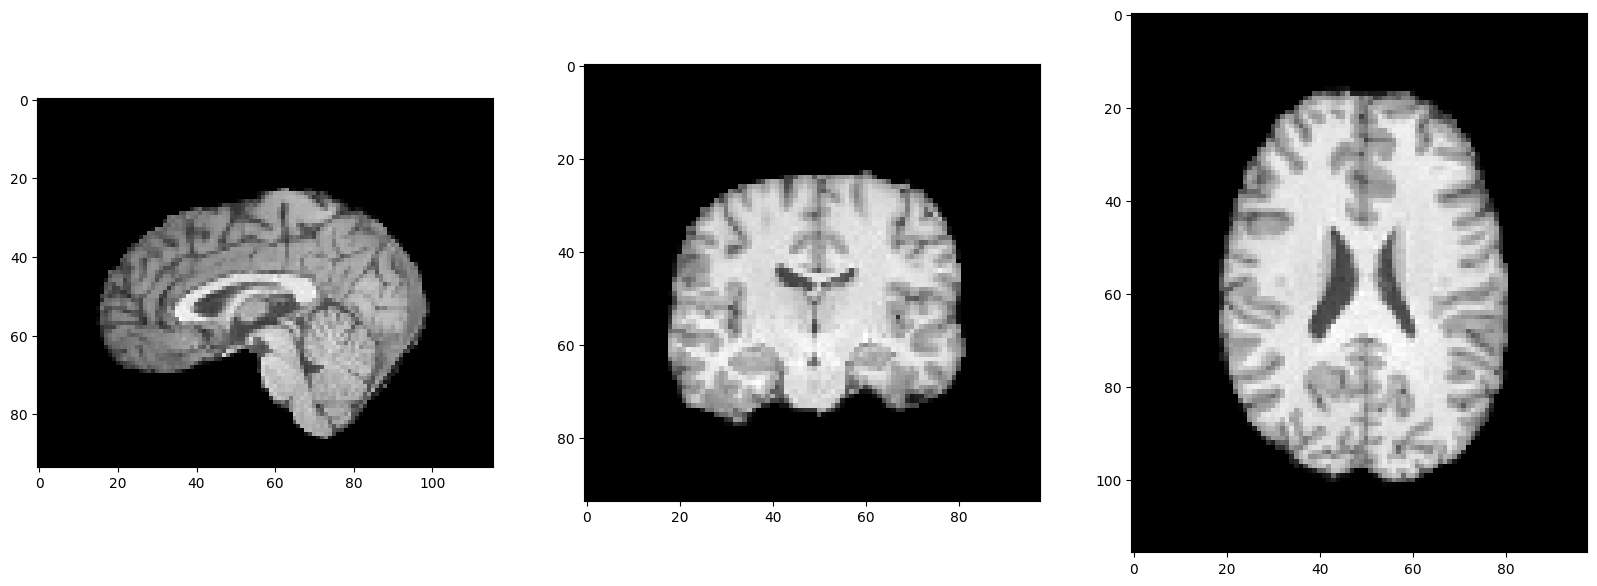

In [3]:
file = './data/brain_age/images/sub-CC110033_T1w_unbiased.nii.gz'

image = nib.load(file).get_fdata()

f, axarr = plt.subplots(1, 3, figsize=(20, 10))
H, W, D = image.shape
axarr[0].imshow(np.flip(image[H // 2, :, :].T, axis=0), cmap='gray')
axarr[1].imshow(np.flip(image[:, W // 2, :].T, axis=0), cmap='gray')
axarr[2].imshow(image[:, :, D // 2].T, cmap='gray')
plt.show()

## Data loading and visualization

Let's first load all the data and make a tranin/val/test split

In [4]:
paths = sorted(glob.glob('data/brain_age/segs_refs/*'))
filenames, segmentations = load_segmentations(paths)

100%|██████████| 652/652 [00:06<00:00, 93.94it/s]


In [5]:
np.random.seed(10282022)

all_keys = np.asarray(range(len(filenames)))
ratio_test = int(0.1 * len(all_keys))  # 10% val; 10% test
val_keys = np.random.choice(all_keys, 2 * ratio_test, replace=False)
test_keys = np.random.choice(val_keys, ratio_test, replace=False)

train_files, val_files, test_files = [], [], []
segmentations_train, segmentations_val, segmentations_test =  [],  [], []
for scan_id in tqdm(all_keys):
  scan = f'data/brain_age/images/sub-{filenames[scan_id]}_T1w_unbiased.nii.gz'
  seg = segmentations[scan_id]
  if scan_id in test_keys:
      test_files.append(scan)
      segmentations_test.append(seg)
  elif scan_id in val_keys:
      val_files.append(scan)
      segmentations_val.append(seg)
  else:
      train_files.append(scan)
      segmentations_train.append(seg)
print(f'{len(train_files)} train files')
print(f'{len(val_files)} val files')
print(f'{len(test_files)} test files')

100%|██████████| 652/652 [00:00<00:00, 64671.20it/s]

522 train files
65 val files
65 test files


Let's visualize one validations sample

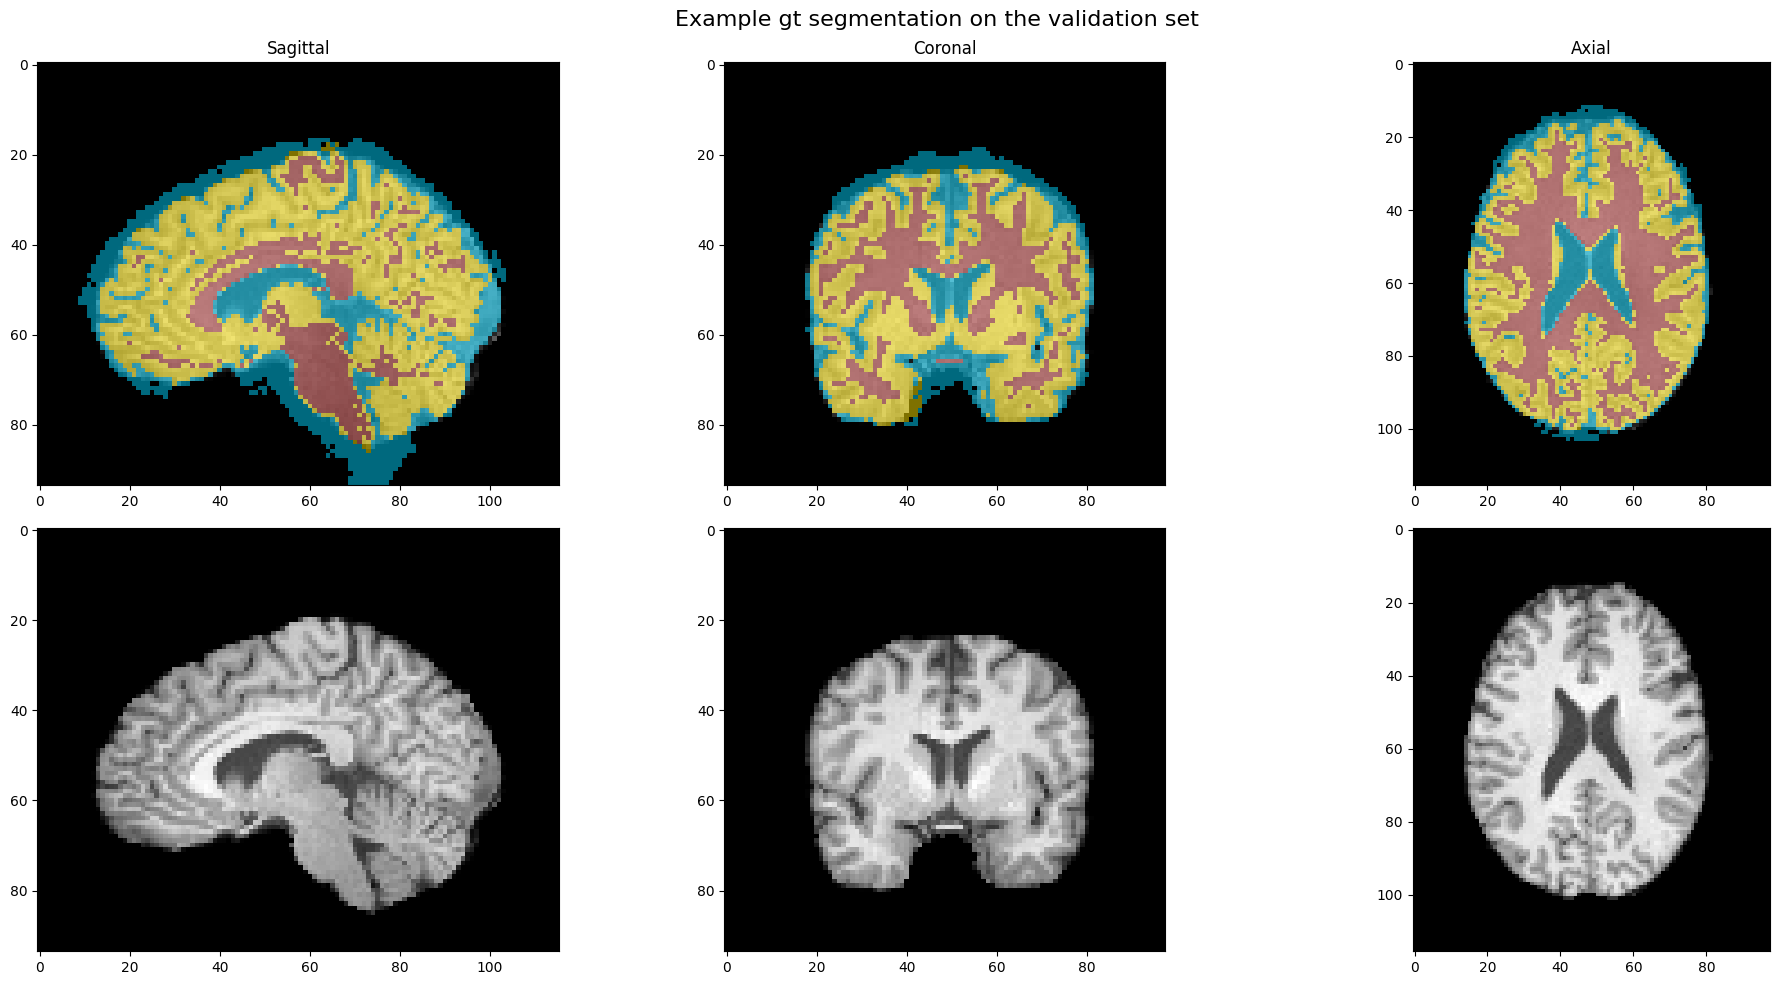

In [ ]:
im = load_nii(val_files[0])
plot_segmentations(im, segmentations_val[0], i=47, title='Example gt segmentation on the validation set')

# Task 1: Evaluation and Visualization

**Q1a**. We first have to define how good our predicted segmentations are. Implement the evaluation functions below.

In [53]:
def Dice(predictions, gt):
  num_patients = predictions.shape[0]
  num_classes = predictions.shape[1]  # Assuming the first dimension represents classes
  dice_scores = np.zeros((num_patients, num_classes))

  for patient in range(num_patients):
      for class_idx in range(num_classes):
          intersection = np.sum((predictions[patient, class_idx] * gt[patient, class_idx]))
          union = np.sum(predictions[patient, class_idx]) + np.sum(gt[patient, class_idx])
          dice_scores[patient, class_idx] = (2.0 * intersection) / (union + 1e-8)

  mean_per_patient = np.mean(dice_scores, axis=1)
  std_per_patient = np.std(dice_scores, axis=1)
  mean = np.mean(mean_per_patient)
  std = np.mean(std_per_patient)
  return mean, std

def Precision(predictions, gt):
    num_patients = predictions.shape[0]
    num_classes = predictions.shape[1]  # Assuming the first dimension represents classes
    precision_scores = np.zeros((num_patients, num_classes))

    for patient in range(num_patients):
        for class_idx in range(num_classes):
            true_positives = np.sum((predictions[patient, class_idx] * gt[patient, class_idx]))
            false_positives = np.sum(predictions[patient, class_idx]) - true_positives
            precision_scores[patient, class_idx] = true_positives / (true_positives + false_positives + 1e-8)

    mean_per_patient = np.mean(precision_scores, axis=1)
    std_per_patient = np.std(precision_scores, axis=1)
    mean_precision = np.mean(mean_per_patient)
    std_precision = np.mean(std_per_patient)

    return mean_precision, std_precision

def Recall(predictions, gt):
    num_patients = predictions.shape[0]
    num_classes = predictions.shape[1]  # Assuming the first dimension represents classes
    recall_scores = np.zeros((num_patients, num_classes))

    for patient in range(num_patients):
        for class_idx in range(num_classes):
            true_positives = np.sum((predictions[patient, class_idx] * gt[patient, class_idx]))
            false_negatives = np.sum(gt[patient, class_idx]) - true_positives
            # print("true_positives",true_positives)
            # print("false_negatives",false_negatives)
            recall_scores[patient, class_idx] = true_positives / (true_positives + false_negatives + 1e-8)

    mean_per_patient = np.mean(recall_scores, axis=1)
    std_per_patient = np.std(recall_scores, axis=1)
    mean_recall = np.mean(mean_per_patient)
    std_recall = np.mean(std_per_patient)

    return mean_recall, std_recall

**Q1b**. Next, we want to visualize the best- and worst-performing samples in the test set. Implement a function that evaluates the entire test dataset and outputs the index of the best and worst performing samples according to the Dice coefficient.

In [51]:
def get_best_and_worst_ids(predictions):

    dice_scores = []

    for i in range(len(test_files)):
        gt = segmentations_test[i]
        # x=torch.argmax(gt_test_all, dim=1) ##
        # gt = x[i]   ##
        dice_score, _ = Dice(predictions[i], gt)
        dice_scores.append(dice_score)

    dice_scores = np.array(dice_scores)
    best_id = np.argmax(dice_scores)
    worst_id = np.argmin(dice_scores)
    best_performance = dice_scores[best_id]
    worst_performance = dice_scores[worst_id]

    return {
        'best_id': best_id,
        'best_performance': best_performance,
        'worst_id': worst_id,
        'worst_performance': worst_performance}

def visualize_best_and_worst_samples(predictions, i_best=47, i_worst=47):
    return_dict = get_best_and_worst_ids(predictions)

    best_id = return_dict['best_id']
    plot_segmentations(load_nii(test_files[best_id]), predictions[best_id], i=i_best,
                       title=f'Best prediction on the test set (Dice: {return_dict["best_performance"]:.2f})')

    worst_id = return_dict['worst_id']
    plot_segmentations(load_nii(test_files[worst_id]), predictions[worst_id], i=i_worst,
                       title=f'Worst prediction on the test set (Dice: {return_dict["worst_performance"]:.2f})')

**Q1c**. Given a set of predictions for a number of models, create a summary figure of your choice (e.g. table, bar plot) which visualizes all of the metric values. Visualize multiple metrics (Dice coefficient, precision, and recall), each computed for every tissue type. A sample dictionary is provided below.

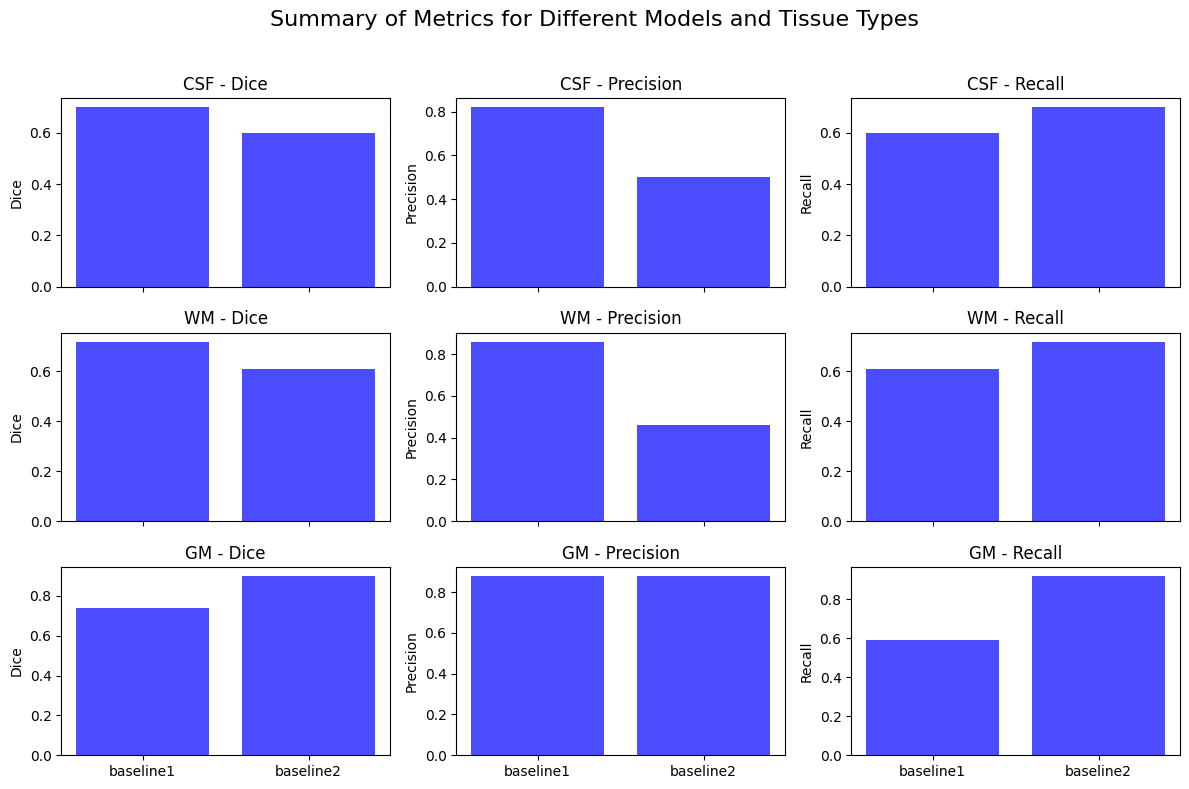

In [8]:
def get_results_dictionary(predictions_all, gt_test_all):
    class_labels = ['CSF', 'WM', 'GM']

    dice_values = []
    precision_values = []
    recall_values = []

    for class_label in range(3):
        Dice = 0
        for pred, target in zip(predictions_all[:, class_label], gt_test_all[:, class_label]):
            intersection = torch.sum(target * pred)
            union = torch.sum(target) + torch.sum(pred) + 1e-10
            current_dice = ((2 * intersection) / union).item()
            Dice += current_dice
        Dice /= len(gt_test_all)
        dice_values.append(Dice)

        true_positives = 0
        false_positives = 0
        false_negatives = 0

        for pred, target in zip(predictions_all[:, class_label], gt_test_all[:, class_label]):
            intersection = torch.sum(target * pred)
            false_positives += torch.sum(pred) - intersection
            true_positives += intersection
            false_negatives += torch.sum(target) - intersection

        precision_values.append(true_positives / (true_positives + false_positives + 1e-10))
        recall_values.append(true_positives / (true_positives + false_negatives + 1e-10))

    # Create the final dictionary
    result_dict = {}
    for i, label in enumerate(class_labels):
        result_dict[label] = {
            'dice': dice_values[i],
            'precision': precision_values[i],
            'recall': recall_values[i],
        }

    final_dict = {}
    for tissue_type, values in result_dict.items():
        if tissue_type not in final_dict:
            final_dict[tissue_type] = {'dice': [], 'precision': [], 'recall': []}

        final_dict[tissue_type]['dice'].append(float(values['dice']))
        final_dict[tissue_type]['precision'].append(float(values['precision']))
        final_dict[tissue_type]['recall'].append(float(values['recall']))

    return final_dict

def plot_results_summary(results_dict: Dict[str, Dict[str, Dict[str, str]]]) -> None:

    tissue_types = list(results_dict.keys())
    metrics = ['dice', 'precision', 'recall']
    num_metrics = len(metrics)

    fig, axes = plt.subplots(len(tissue_types), num_metrics, figsize=(12, 8), sharex=True)
    fig.suptitle('Summary of Metrics for Different Models and Tissue Types', fontsize=16)

    for i, tissue_type in enumerate(tissue_types):
        for j, metric in enumerate(metrics):
            values = np.array(results_dict[tissue_type][metric])
            axes[i, j].bar(range(len(values)), values, color='blue', alpha=0.7)
            axes[i, j].set_title(f'{tissue_type} - {metric.capitalize()}')
            axes[i, j].set_xticks(range(len(sample_results)))
            axes[i, j].set_xticklabels(sample_results.keys())
            axes[i, j].set_ylabel(metric.capitalize())

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout for the title
    plt.show()

# ----------------------------------- END ------------------------------------

sample_results = {
    'baseline1': {
        'CSF': {'dice': '0.7', 'precision': '0.82', 'recall': '0.6'},
        'WM': {'dice': '0.72', 'precision': '0.86', 'recall': '0.61'},
        'GM': {'dice': '0.74', 'precision': '0.88', 'recall': '0.59'},
    },
    'baseline2': {
        'CSF': {'dice': '0.6', 'precision': '0.5', 'recall': '0.7'},
        'WM': {'dice': '0.61', 'precision': '0.46', 'recall': '0.72'},
        'GM': {'dice': '0.9', 'precision': '0.88', 'recall': '0.92'},
    }
}

results_dict = get_results_dictionary(sample_results)
# print(results_dict)
plot_results_summary(results_dict)
# plot_results_summary(sample_results)

# Task 2: Unsupervised segmentation

The first approach aims to segment the brain tissues, including grey matter (GM), white matter (WM), cerebrospinal fluid (CSF), and background using unsupervised classical machine learning techniques.

Different unsupervised techniques to leverage the different intensity profile of the tissues should be explored.

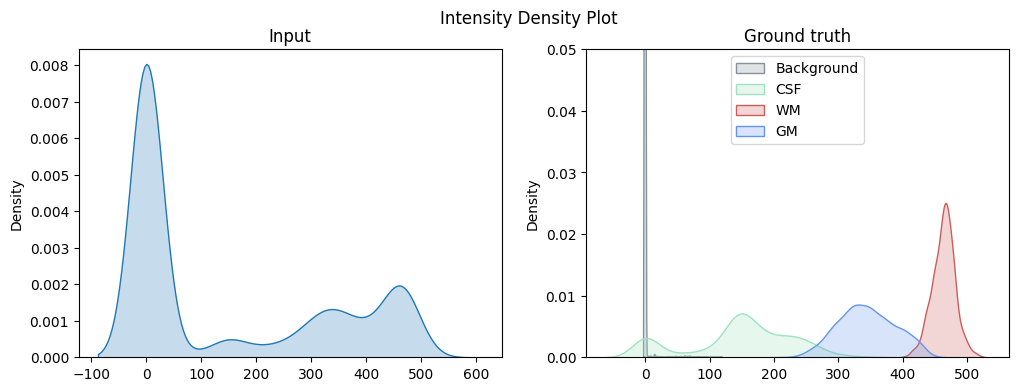

In [9]:
slice_id = 0
im_ = load_nii(val_files[slice_id])[:,:,47].flatten()
seg_ = segmentations_val[slice_id][:,:,47].flatten()

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
fig.suptitle('Intensity Density Plot')

sns.kdeplot(im_, ax=axes[0], fill=True)
axes[0].set_title('Input')

sns.kdeplot(im_[np.argwhere(seg_ == 0)][:, 0], ax=axes[1], fill=True, color='#85929E', label='Background', legend=True)
sns.kdeplot(im_[np.argwhere(seg_ == 1)][:, 0], ax=axes[1], fill=True, color='#9FE2BF', label='CSF', legend=True)
sns.kdeplot(im_[np.argwhere(seg_ == 3)][:, 0], ax=axes[1], fill=True, color='#CD5C5C', label='WM', legend=True)
sns.kdeplot(im_[np.argwhere(seg_ == 2)][:, 0], ax=axes[1], fill=True, color='#6495ED', label='GM', legend=True)
axes[1].set_ylim(0, 0.05)
axes[1].set_title('Ground truth')
plt.legend(loc=9, labels=['Background', 'CSF', 'WM', 'GM'])

## Unsupervised Learning

Here, you should experiment with different *classical* unsupervised machine learning methods, e.g., clustering, density estimation, etc... (at least two different methods). Hint: sklearn has implementations of unsupervised methods

**HINT**: You can predict the different classes of intensities even without any training!

**HINT**: You can evaluate every volume slice-by-slice if the whole volume does not fit in the memory.

#### QUESTION Q2a.
Implement an unsupervised learning method of your choice.
Evaluate the Dice scores (separately for every tissue type) for the whole test set using method 1.

In [ ]:
# # Unsupervised method 1
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import seaborn as sns

pred_seg_1= []
# Helper function to perform unsupervised segmentation using k-means
def unsupervised_kmeans(data, num_classes):
    flattened_data = data.reshape((-1, 1))
    kmeans = KMeans(n_clusters=num_classes, random_state=42)
    labels = kmeans.fit_predict(flattened_data)
    return labels.reshape(data.shape)


for i in range(len(test_files)):
# for i in range(3):
    im = load_nii(test_files[i])
    pred_seg = unsupervised_kmeans(im, num_classes=4)
    pred_seg_1.append(pred_seg)


In [54]:
get_best_and_worst_ids(pred_seg_1)

{'best_id': 60,
 'best_performance': 0.8990830827324747,
 'worst_id': 12,
 'worst_performance': 0.3853022373498483}

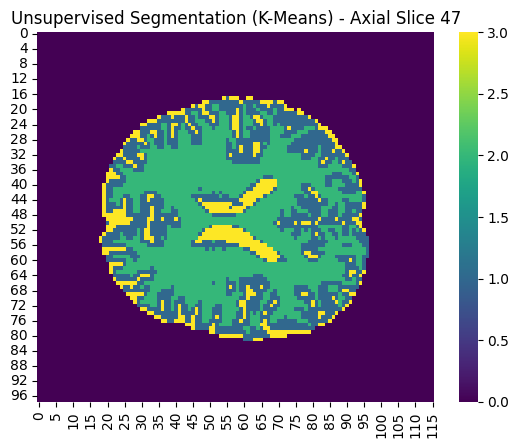

In [ ]:
# # Plot the obtained results for volume 0 and axial slice 47 of the test set (density estimations)
sns_plot_1 = sns.heatmap(pred_seg_1[0][:, :, 47], cmap="viridis")
plt.title("Unsupervised Segmentation (K-Means) - Axial Slice 47")
plt.show()

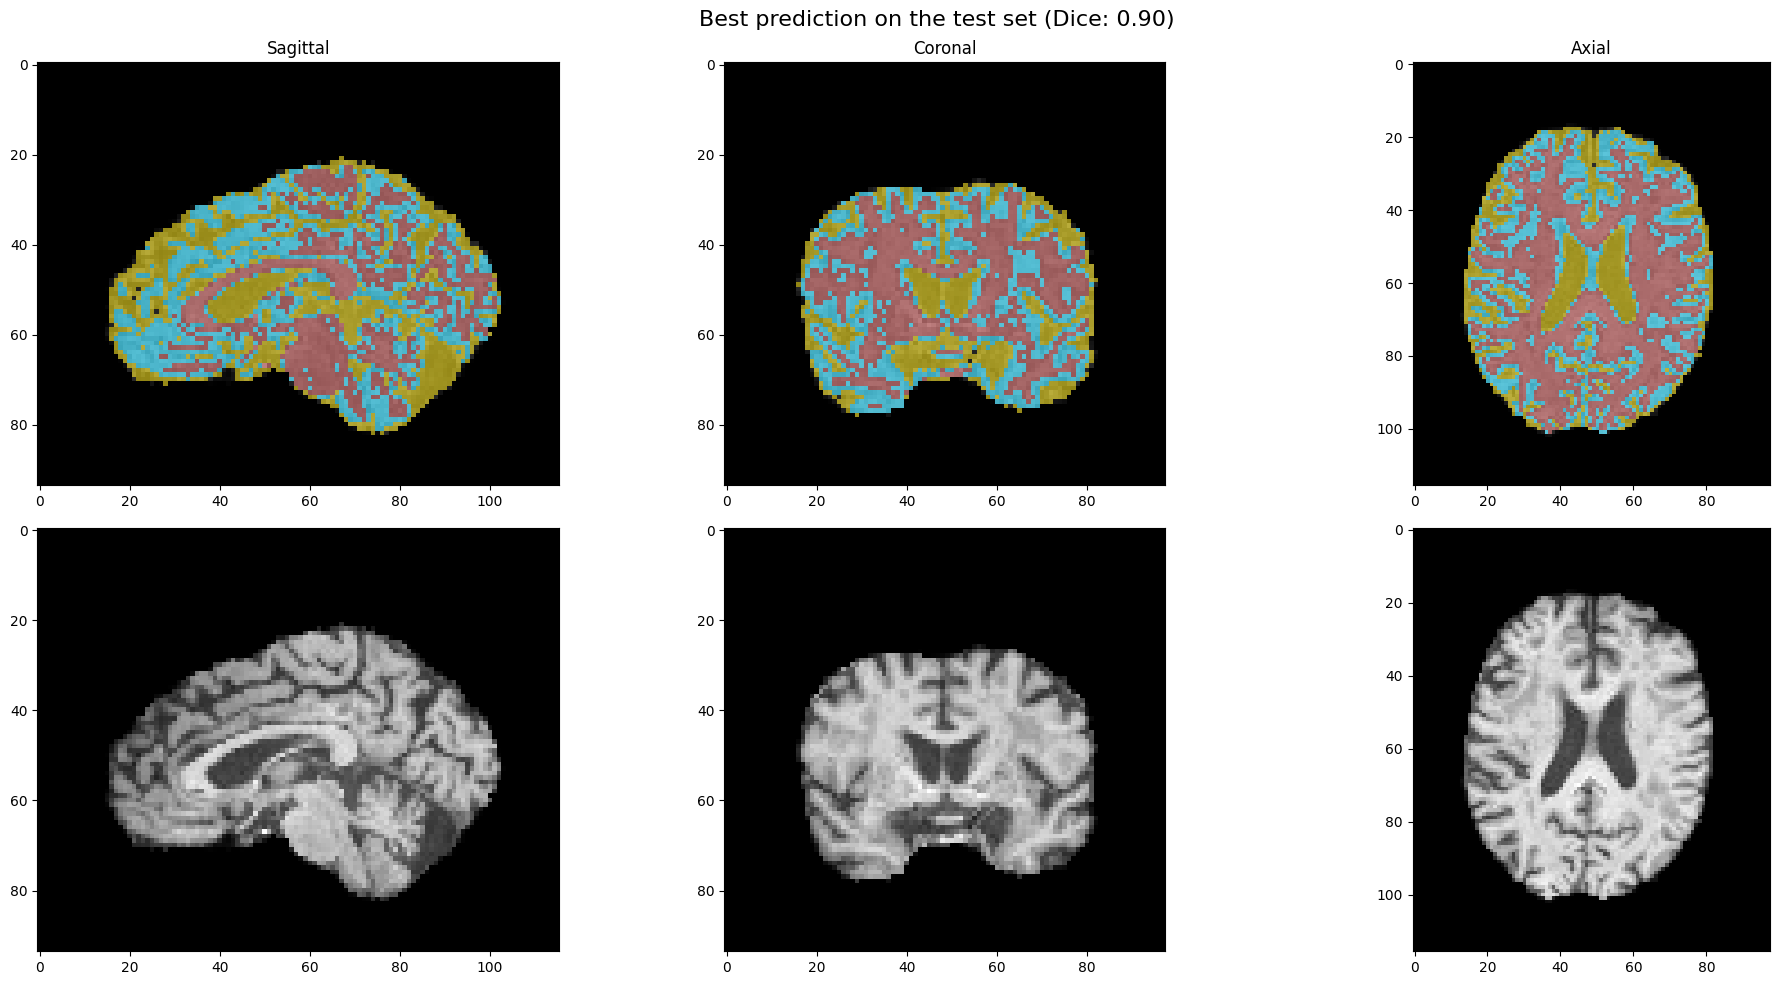

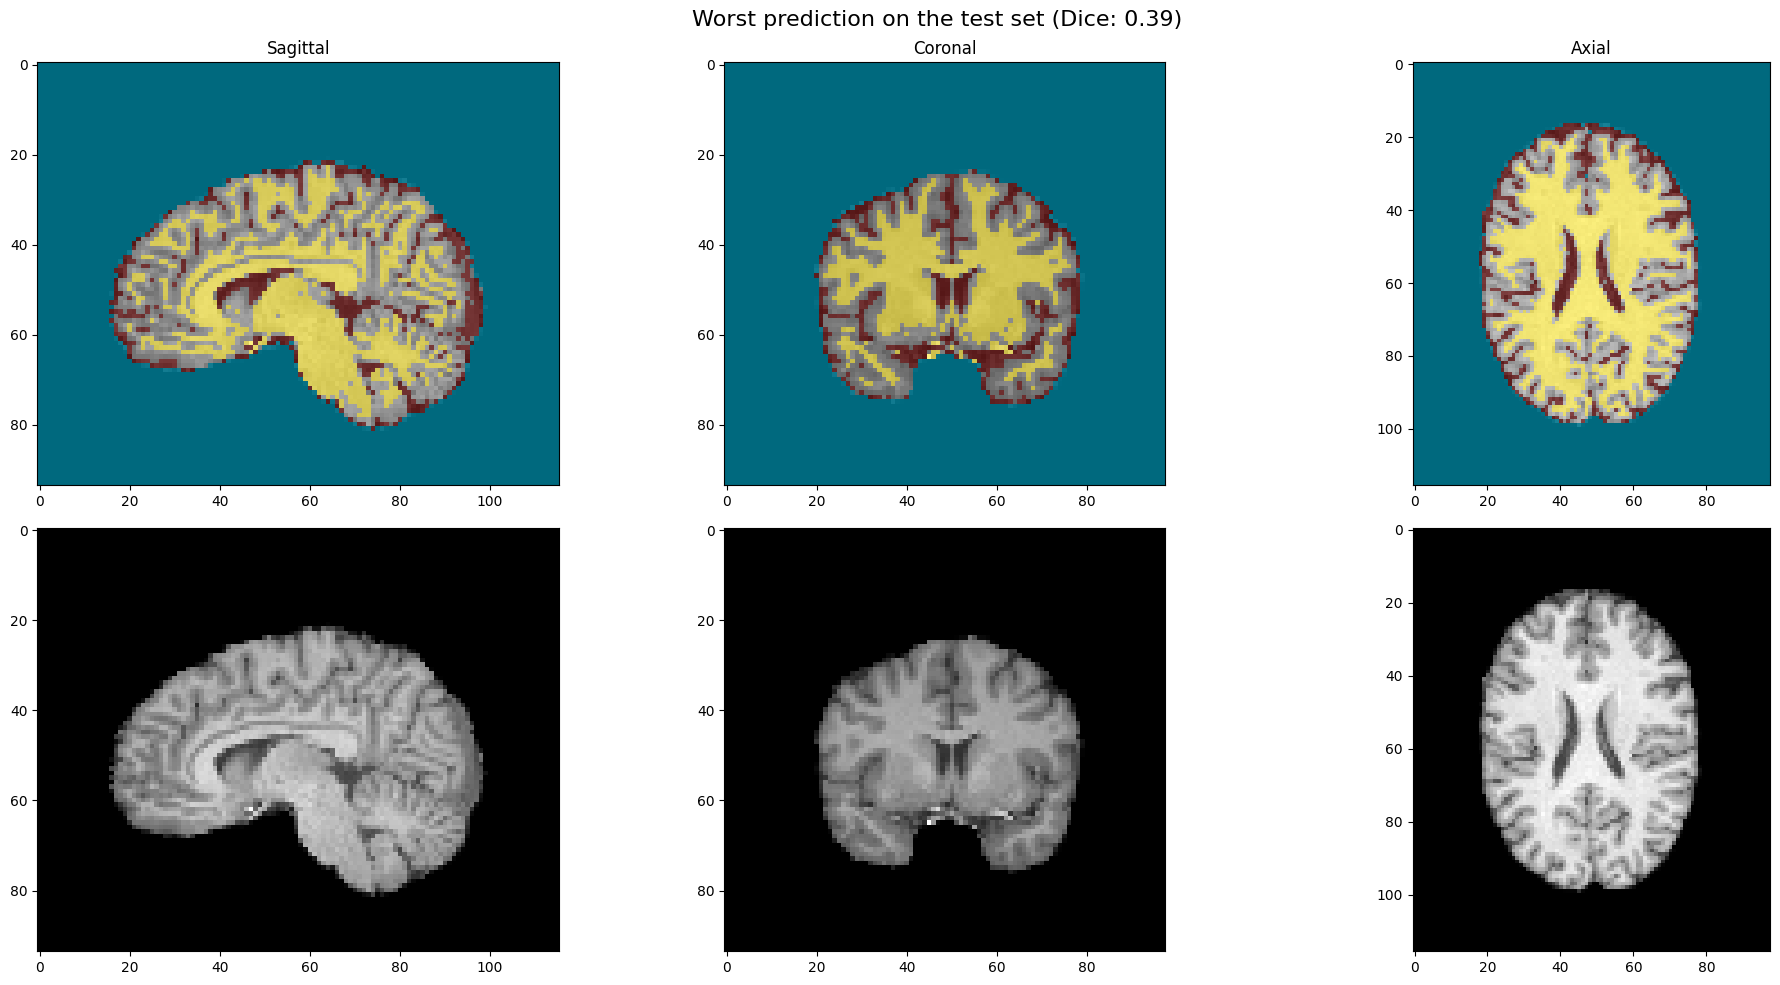

In [ ]:
# Visualize the best and worst predictions on the test set for method 1
visualize_best_and_worst_samples(pred_seg_1)

#### QUESTION Q2b.
Implement a second unsupervised learning method of your choice.
Evaluate the Dice scores (separately for every tissue type) for the whole test set using method 2.

In [39]:
# # Unsupervised method 2

pred_seg_2=[]
# Helper function to perform unsupervised segmentation using Gaussian Mixture Model (GMM)
def unsupervised_gmm(data, num_classes):
    flattened_data = data.reshape((-1, 1))
    gmm = GaussianMixture(n_components=num_classes, random_state=42)
    labels = gmm.fit_predict(flattened_data)
    return labels.reshape(data.shape)

for i in range(len(test_files)):
# for i in range(3):
    im = load_nii(test_files[i])
    pred_seg2 = unsupervised_gmm(im, num_classes=4)
    pred_seg_2.append(pred_seg2)

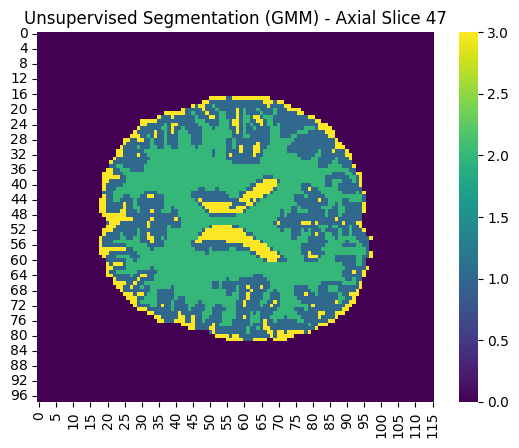

In [ ]:
# # Plot the obtained results for volume 0 and axial slice 47 of the test set (density estimations)

sns_plot_2 = sns.heatmap(pred_seg_2[0][:, :, 47], cmap="viridis")
plt.title("Unsupervised Segmentation (GMM) - Axial Slice 47")
plt.show()

In [ ]:
get_best_and_worst_ids(pred_seg_2)

{'best_id': 14,
 'best_performance': 0.9002708206864241,
 'worst_id': 38,
 'worst_performance': 0.5903457674491992}

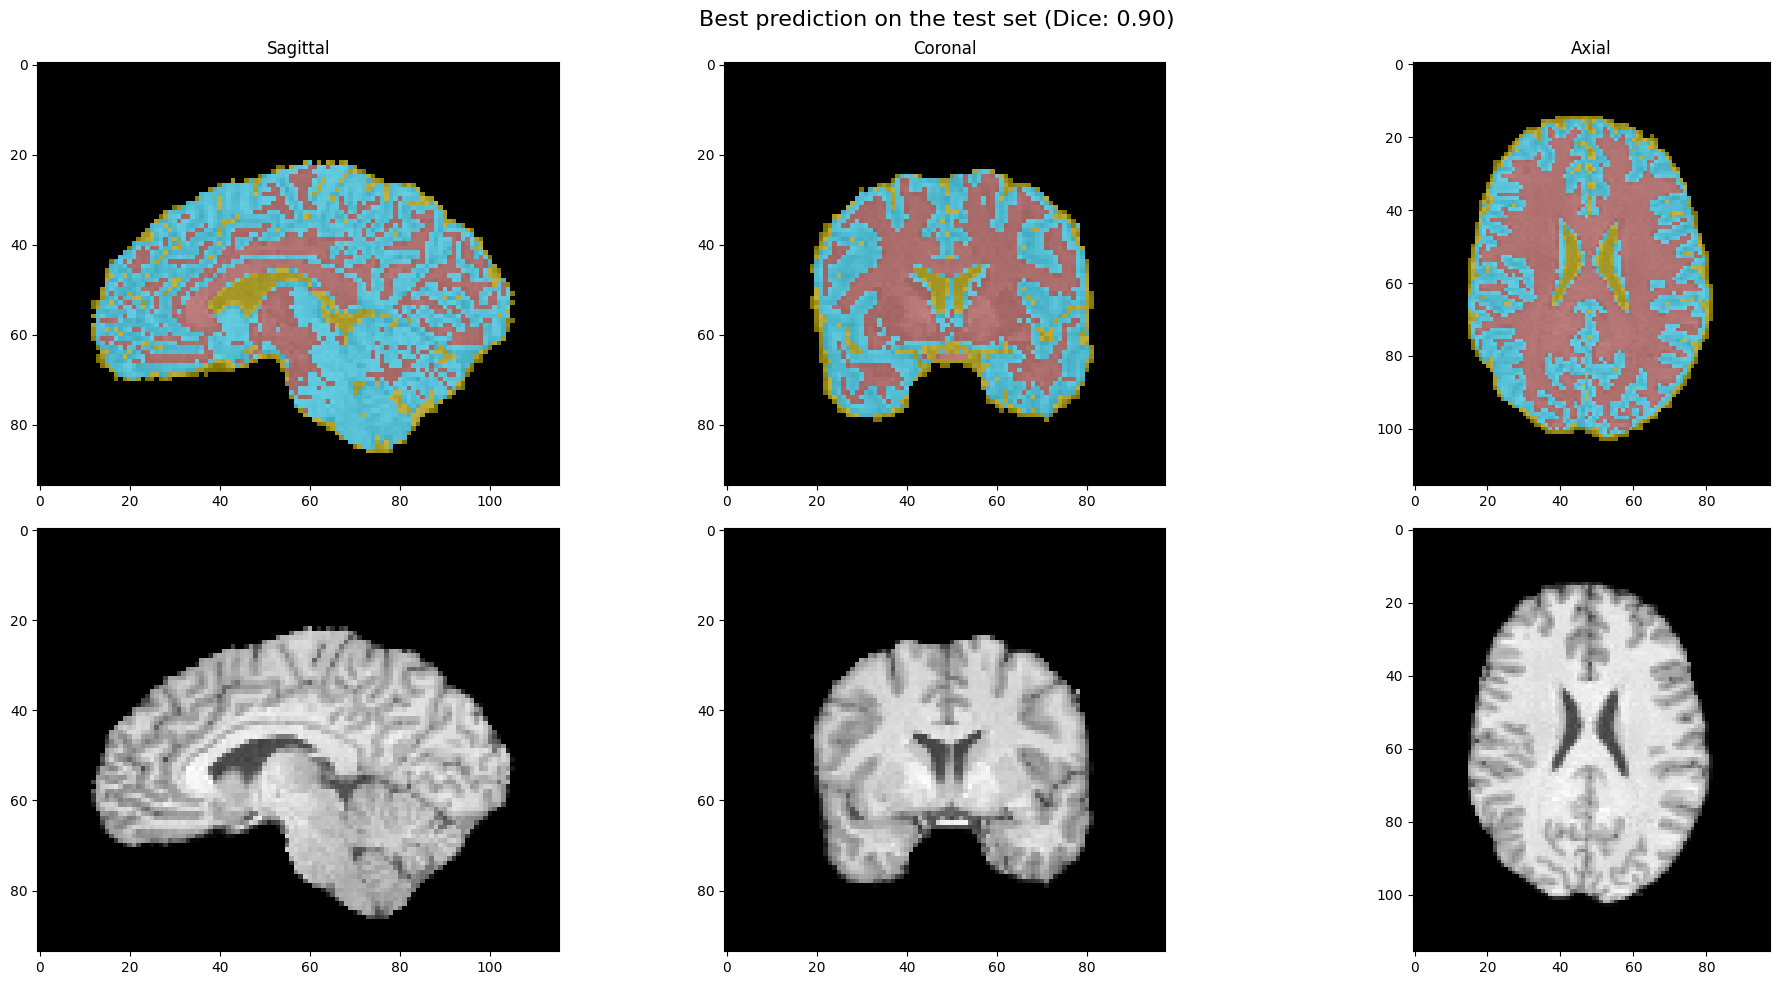

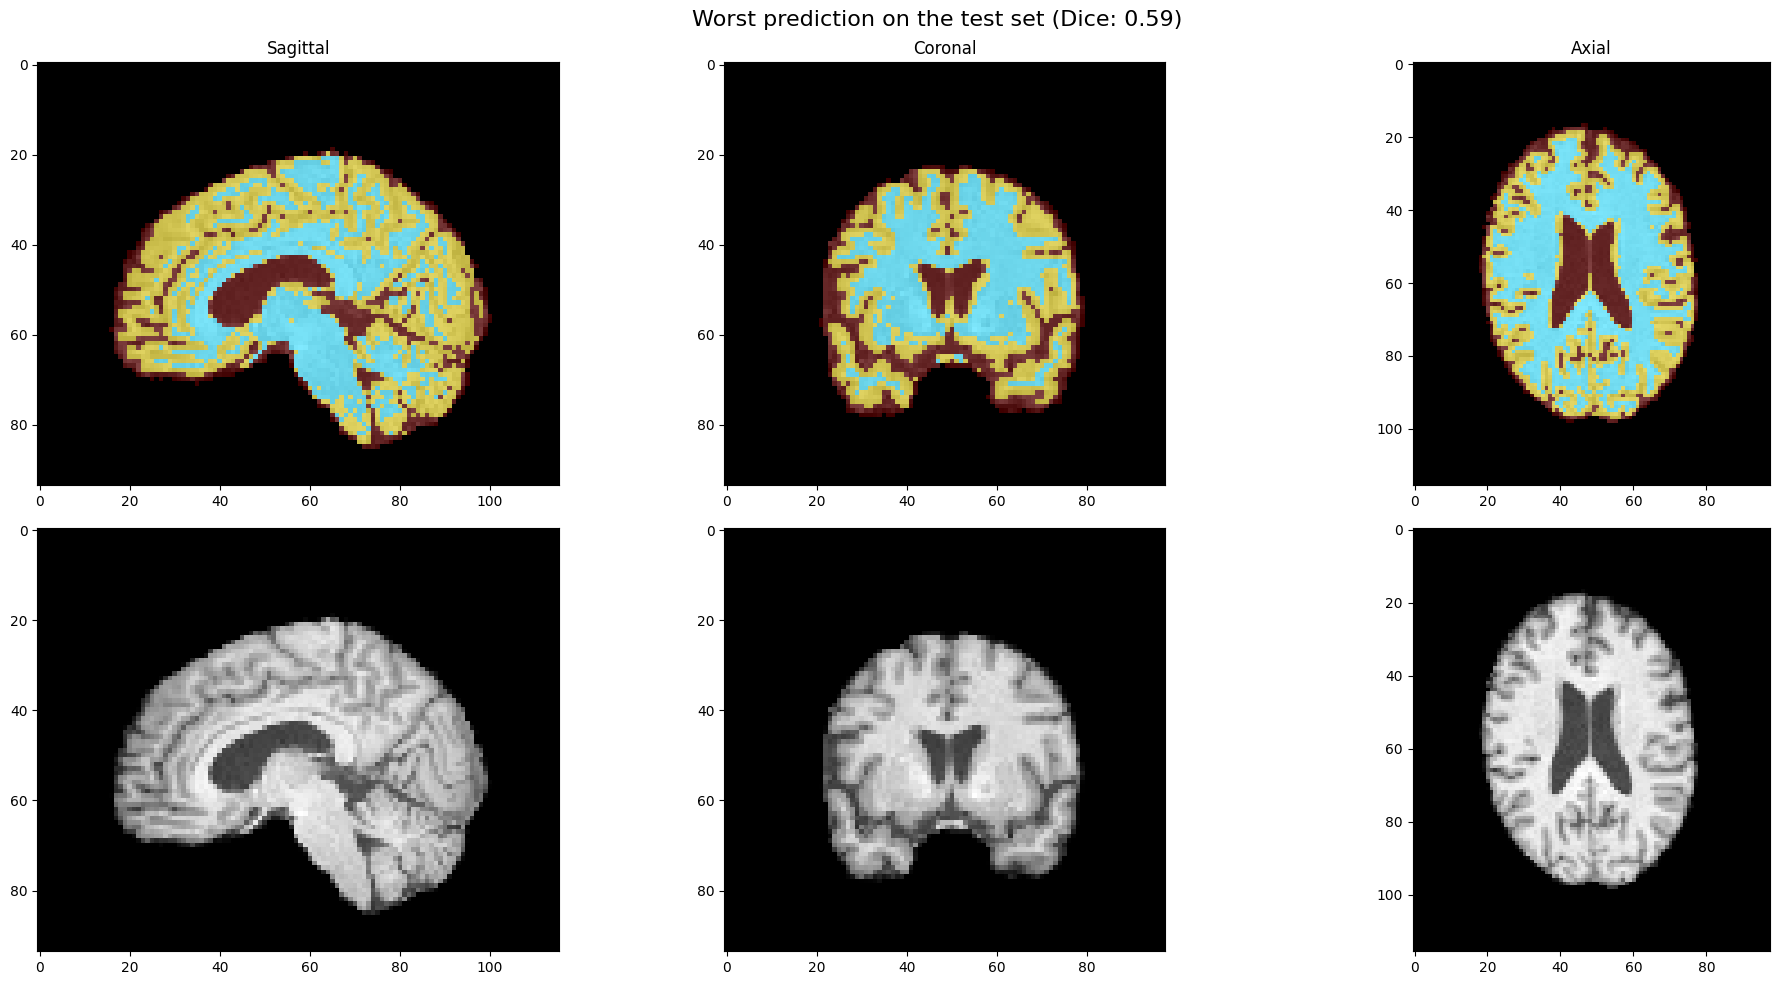

In [ ]:
visualize_best_and_worst_samples(pred_seg_2)

# Task 3: Deep supervised segmentation

Deep Learning (DL) methods achieve state-of-the-art results in many (medical) image analyzis applications, including segmentation. Here, you will implement and train a DL method to segment CSF, WM, GM, and background in brain MRI.

First, let's have a look at the individual channels of the segmentations.

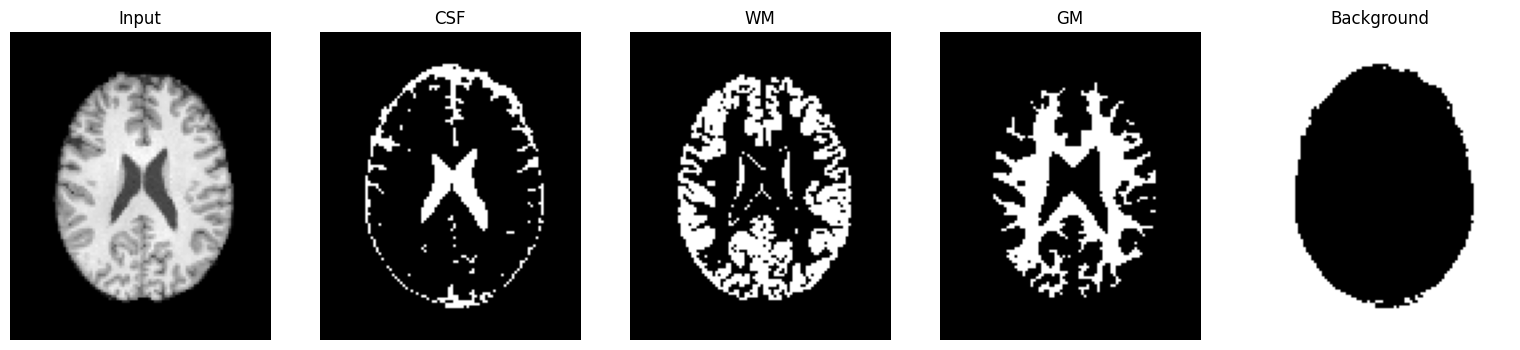

In [ ]:
import matplotlib.pyplot as plt
import copy
im = load_nii(val_files[0])
csf, wm, gm, background = np.zeros(im.shape), np.zeros(im.shape), np.zeros(im.shape), np.zeros(im.shape)
csf[segmentations_val[0]==1] = 1
wm[segmentations_val[0]==2] = 1
gm[segmentations_val[0]==3] = 1
background[segmentations_val[0]==0]=1
elements = [im, csf, wm, gm, background]
elements2 = [csf, wm, gm, background]
# print(torch.tensor(elements2).shape)
titles = ['Input', 'CSF', 'WM', 'GM', 'Background']
diffp, axarr = plt.subplots(1, len(elements), gridspec_kw={'wspace': 0, 'hspace': 0})
diffp.set_size_inches(len(elements) * 4, 4)
for idx_arr in range(len(axarr)):
    axarr[idx_arr].axis('off')
    el = np.squeeze(elements[idx_arr][:,:,47])
    axarr[idx_arr].imshow(el.T, cmap='gray')
    axarr[idx_arr].set_title(titles[idx_arr])

## DL-based segmentation

Define and train a U-Net for segmentation (use the train, val, and test splits defined above).

Feel free to choose:
* the number of layers
* the number of features within convolutional layers
* number of convolutions within each layer
* concatenation strategy
* ...

HINT: You can use pre-defined models, e.g., from torchvision, but train them from scratch (no pre-training)

In [10]:
!pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.3 MB/s eta 0:00:00


We are currently employing the UNet architecture from MONAI. Initially, we resized the volumes to (64, 64, 64) to ensure compatibility with the model. Although we initially attempted to apply DiceLoss, we encountered a class imbalance issue. Subsequently, we switched to using DiceFocal. The training process can be observed at the end of the code, which includes visualizations of some training and validation samples

In [11]:
#second trial dicefocal
import torch
from monai.networks.nets import UNet
from monai.losses import DiceLoss, DiceFocalLoss, FocalLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.data import DataLoader, Dataset
from monai.transforms import (Compose,Resize,ToTensor)
transformimage = Compose([Resize(spatial_size=(64,64,64)),ToTensor()])
transformtarget = Compose([Resize(spatial_size=(64,64,64),mode="nearest"),ToTensor()])

# Define the 3D U-Net model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims = 3,
    in_channels = 1,
    out_channels = 3,
    channels=(64, 128,256,512),
    strides = (2,2 ,2),
    ).to(device)

# Define loss function and optimizer
criterion = DiceFocalLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

# Training loop
num_epochs = 70
flag_train_data=1
flag_val_data=1
all_train_elements=[]
all_val_elements=[]

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    i_train_data=0
    i_val_data=0

    for inputs, targets in zip(train_files, segmentations_train):
        inputs = torch.from_numpy(load_nii(inputs)).unsqueeze(0).to(device)
        inputs = transformimage(inputs)

        inputs = inputs.unsqueeze(0)
        # print(inputs.shape)
        # plt.subplot(2,4,1)
        # plt.imshow(inputs[0][0][:,:,32].cpu(),cmap='gray')


        outputs = model(inputs)
        outputs = outputs.to(device)

        if (flag_train_data):
          csf, wm, gm, background = np.zeros((98, 116, 94)), np.zeros((98, 116, 94)), np.zeros((98, 116, 94)), np.zeros((98, 116, 94))
          csf[targets==1] = 1
          wm[targets==2] = 1
          gm[targets==3] = 1
          background[targets==0]=1
          elements = [csf, wm, gm, background]
          elements = torch.tensor(elements)
          # elements = transforms(elements)
          elements = transformtarget(elements).unsqueeze(0)
          elements = elements.to(device)
          all_train_elements.append(elements)

        if (flag_train_data):
          loss = criterion(outputs, elements[:,:3])
        else:
          # if (i_train_data%30 == 0):
          #   plt.subplot(2,4,2)
          #   plt.imshow(all_train_elements[i_train_data][0][0][:,:,32].cpu(),cmap='gray')
          #   plt.subplot(2,4,3)
          #   plt.imshow(all_train_elements[i_train_data][0][1][:,:,32].cpu(),cmap='gray')
          #   plt.subplot(2,4,4)
          #   plt.imshow(all_train_elements[i_train_data][0][2][:,:,32].cpu(),cmap='gray')

          #   plt.subplot(2,4,6)
          #   plt.imshow(outputs[0][0][:,:,32].cpu().detach().numpy() >0,cmap='gray')
          #   plt.subplot(2,4,7)
          #   plt.imshow(outputs[0][1][:,:,32].cpu().detach().numpy() >0,cmap='gray')
          #   plt.subplot(2,4,8)
          #   plt.imshow(outputs[0][2][:,:,32].cpu().detach().numpy() >0,cmap='gray')
          #   plt.show()

          loss = criterion(outputs, all_train_elements[i_train_data][:,:3])
          # if (i_train_data%30 == 0):
          #   print(loss.item())
          i_train_data += 1


        epoch_loss += loss.item()
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    flag_train_data=0

    # Validation
    model.eval()
    with torch.no_grad():
        total_val_loss = 0.0
        for images_val, mask_val in zip(val_files, segmentations_val):

            images_val = torch.from_numpy(load_nii(images_val)).unsqueeze(0).to(device)
            images_val = transformimage(images_val)
            images_val = images_val.unsqueeze(0)

            outputs_val = model(images_val)
            outputs_val = outputs_val.to(device)

            if (flag_val_data):
              csf, wm, gm, background = np.zeros((98, 116, 94)), np.zeros((98, 116, 94)), np.zeros((98, 116, 94)), np.zeros((98, 116, 94))
              csf[mask_val==1] = 1
              wm[mask_val==2] = 1
              gm[mask_val==3] = 1
              background[mask_val==0]=1
              elements = [csf, wm, gm, background]
              elements = torch.tensor(elements)
              elements = transformtarget(elements).unsqueeze(0)
              elements = elements.to(device)
              all_val_elements.append(elements)


            if(flag_val_data):
              val_loss = criterion(outputs_val, elements[:,:3])
            else:

              # if (i_val_data%25 == 0):
              #   plt.subplot(2,4,2)
              #   plt.imshow(all_val_elements[i_val_data][0][0][:,:,32].cpu(),cmap='gray')
              #   plt.subplot(2,4,3)
              #   plt.imshow(all_val_elements[i_val_data][0][1][:,:,32].cpu(),cmap='gray')
              #   plt.subplot(2,4,4)
              #   plt.imshow(all_val_elements[i_val_data][0][2][:,:,32].cpu(),cmap='gray')

              #   plt.subplot(2,4,6)
              #   plt.imshow(outputs_val[0][0][:,:,32].cpu().detach().numpy() >0,cmap='gray')
              #   plt.subplot(2,4,7)
              #   plt.imshow(outputs_val[0][1][:,:,32].cpu().detach().numpy() >0,cmap='gray')
              #   plt.subplot(2,4,8)
              #   plt.imshow(outputs_val[0][2][:,:,32].cpu().detach().numpy() >0,cmap='gray')
              #   plt.show()

              val_loss = criterion(outputs_val, all_val_elements[i_val_data][:,:3])
              # if (i_val_data%25 == 0):
              #   print(loss.item())
              i_val_data += 1

            total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_files)
        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss}")
    flag_val_data=0

<ipython-input-11-f8a5b8bdb490>:59: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  elements = torch.tensor(elements)


Epoch [1/70], Validation Loss: 0.889870861860422
Epoch [2/70], Validation Loss: 0.8112586067273067
Epoch [3/70], Validation Loss: 0.7481718769440284
Epoch [4/70], Validation Loss: 0.6915548113676218
Epoch [5/70], Validation Loss: 0.6397960763711196
Epoch [6/70], Validation Loss: 0.5929593865688031
Epoch [7/70], Validation Loss: 0.5517138792918279
Epoch [8/70], Validation Loss: 0.5161493585659908
Epoch [9/70], Validation Loss: 0.485775841657932
Epoch [10/70], Validation Loss: 0.4599465026305272
Epoch [11/70], Validation Loss: 0.43800308796075677
Epoch [12/70], Validation Loss: 0.4192919611930847
Epoch [13/70], Validation Loss: 0.4032927678181575
Epoch [14/70], Validation Loss: 0.3894948354134193
Epoch [15/70], Validation Loss: 0.37755911166851336
Epoch [16/70], Validation Loss: 0.36716773372430067
Epoch [17/70], Validation Loss: 0.3580646120584928
Epoch [18/70], Validation Loss: 0.3500489060695355
Epoch [19/70], Validation Loss: 0.3429321587085724
Epoch [20/70], Validation Loss: 0.33659

Now, we are going to evaluate the model.

In [12]:
import monai
model.eval()
predictions_all = []

with torch.no_grad():
    for images_test, masks_test in zip(test_files, segmentations_test):
        images_test = torch.from_numpy(load_nii(images_test)).unsqueeze(0).to(device)
        images_test = transformimage(images_test)
        images_test = images_test.unsqueeze(0)

        # Forward pass
        outputs_test = model(images_test)
        outputs_test=outputs_test.to(device)
        # print(torch.tensor(outputs_test).shape)
        outputs_test=(outputs_test > 0.5).int()
        # print(outputs_test.shape)

        # Convert outputs and masks to numpy arrays
        predictions_np = outputs_test.cpu().numpy()

        # Append predictions and ground truth for later Dice calculation
        predictions_all.append(predictions_np)

# Concatenate predictions and ground truth along the batch dimension
predictions_all = np.concatenate(predictions_all, axis=0)

In [13]:
from monai.transforms import (Compose,Resize,ToTensor)
transforms = Compose([Resize(spatial_size=(64,64,64),mode="nearest"),ToTensor()])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

im = load_nii(val_files[0])

gt_test_all = []
for masks_test in(segmentations_test):

    csf, wm, gm, background = np.zeros(im.shape), np.zeros(im.shape), np.zeros(im.shape), np.zeros(im.shape)
    csf[masks_test==1] = 1
    wm[masks_test==2] = 1
    gm[masks_test==3] = 1
    background[masks_test==0]=1
    elements = [csf, wm, gm, background]

    #transform
    elements = torch.tensor(elements)
    # print(elements.shape)
    elements = transforms(elements)
    # print(elements.shape)
    gt_test_all.append(elements)

gt_test_all= torch.stack(gt_test_all)
predictions_all= torch.tensor(predictions_all)

Here are the Dice scores for each class.

In [20]:
for class_label in range(3):
  Dice=0
  for pred, target in zip(predictions_all[:,class_label,:,:,:],gt_test_all[:,class_label,:,:,:]):
    intersection = torch.sum(target * pred)
    union = torch.sum(target) + torch.sum(pred) + 1e-10
    current_dice = ((2 * intersection) / union).item()
    Dice += current_dice
  Dice/=len(gt_test_all)
  print("class",class_label, "Dice score")
  print(Dice)

class 0 Dice score
0.769947024492117
class 1 Dice score
0.7757990461129408
class 2 Dice score
0.876230253623082


### Evaluate the Dice scores (separately for every tissue type) for the whole test set.

In [14]:
pred_seg_3 = predictions_all

In [ ]:
# print(pred_seg_3.shape)
# print(torch.tensor(pred_seg_2).shape)
# print(torch.tensor(pred_seg_1).shape)

torch.Size([65, 3, 64, 64, 64])
torch.Size([65, 98, 116, 94])
torch.Size([65, 98, 116, 94])


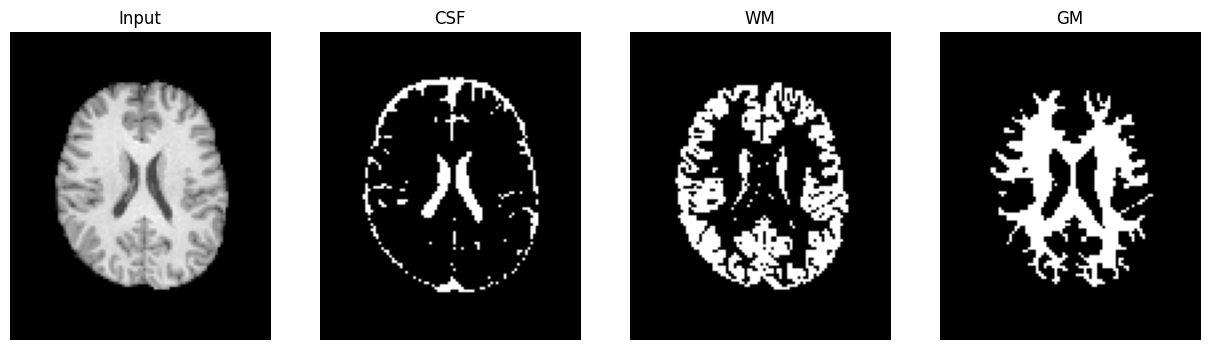

In [57]:
im = load_nii(test_files[0])
csf, wm, gm = np.zeros(im.shape), np.zeros(im.shape), np.zeros(im.shape)
csf[segmentations_test[0]==1] = 1
wm[segmentations_test[0]==2] = 1
gm[segmentations_test[0]==3] = 1
elements = [im, csf, wm, gm]
titles = ['Input', 'CSF', 'WM', 'GM']
diffp, axarr = plt.subplots(1, len(elements), gridspec_kw={'wspace': 0, 'hspace': 0})
diffp.set_size_inches(len(elements) * 4, 4)
for idx_arr in range(len(axarr)):
    axarr[idx_arr].axis('off')
    el = np.squeeze(elements[idx_arr][:,:,47])
    axarr[idx_arr].imshow(el.T, cmap='gray')
    axarr[idx_arr].set_title(titles[idx_arr])

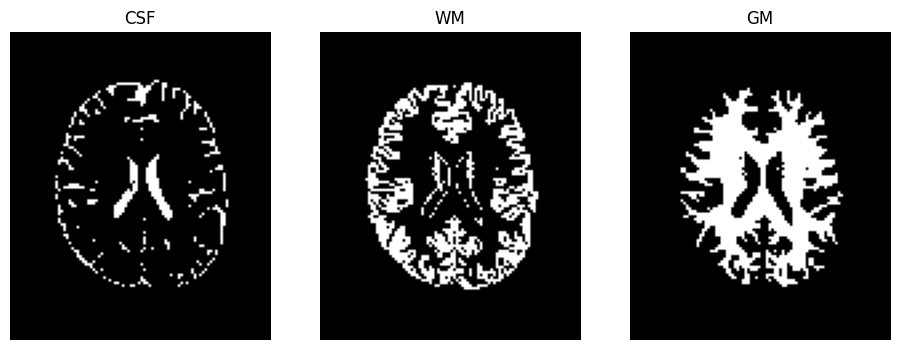

In [30]:
im = load_nii(test_files[0])
csf, wm, gm = np.zeros(im.shape), np.zeros(im.shape), np.zeros(im.shape)
csf[pred_seg_1[0]==3] = 1
wm[pred_seg_1[0]==1] = 1
gm[pred_seg_1[0]==2] = 1
elements = [csf, wm, gm]
titles = ['CSF', 'WM', 'GM']
diffp, axarr = plt.subplots(1, len(elements), gridspec_kw={'wspace': 0, 'hspace': 0})
diffp.set_size_inches(len(elements) * 4, 4)
for idx_arr in range(len(axarr)):
    axarr[idx_arr].axis('off')
    el = np.squeeze(elements[idx_arr][:,:,47])
    axarr[idx_arr].imshow(el.T, cmap='gray')
    axarr[idx_arr].set_title(titles[idx_arr])

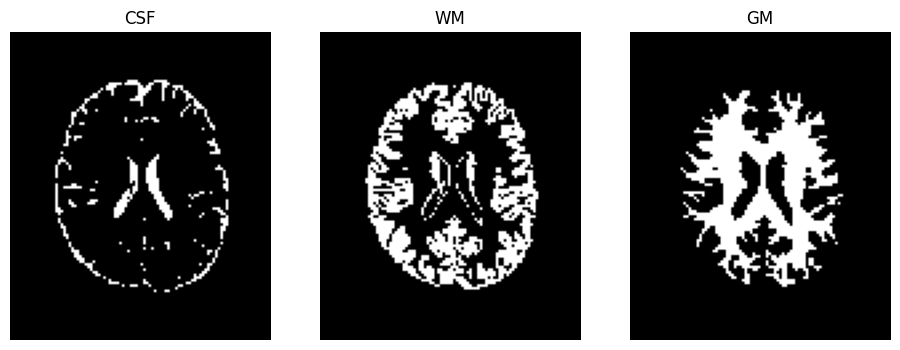

In [ ]:
im = load_nii(test_files[0])
csf, wm, gm = np.zeros(im.shape), np.zeros(im.shape), np.zeros(im.shape)
csf[pred_seg_2[0]==3] = 1
wm[pred_seg_2[0]==1] = 1
gm[pred_seg_2[0]==2] = 1
elements = [csf, wm, gm]
titles = ['CSF', 'WM', 'GM']
diffp, axarr = plt.subplots(1, len(elements), gridspec_kw={'wspace': 0, 'hspace': 0})
diffp.set_size_inches(len(elements) * 4, 4)
for idx_arr in range(len(axarr)):
    axarr[idx_arr].axis('off')
    el = np.squeeze(elements[idx_arr][:,:,47])
    axarr[idx_arr].imshow(el.T, cmap='gray')
    axarr[idx_arr].set_title(titles[idx_arr])

### Summarize the results of all of the segmentation methods implemented.

Now, I will compute the Dice score, precision, and recall for each model.

In [ ]:
def avg_dice(predictions):
    dice_scores = []

    for i in range(len(test_files)):
        gt = segmentations_test[i]
        dice_score, _ = Dice(predictions[i], gt)
        dice_scores.append(dice_score)
    return sum(dice_scores) / len(dice_scores)

In [ ]:
averagedice_pred3=0
for class_label in range(3):
  Dice=0
  for pred, target in zip(predictions_all[:,class_label,:,:,:],gt_test_all[:,class_label,:,:,:]):
    intersection = torch.sum(target * pred)
    union = torch.sum(target) + torch.sum(pred) + 1e-10
    current_dice = ((2 * intersection) / union).item()
    Dice += current_dice
  Dice/=len(gt_test_all)
  averagedice_pred3 += Dice

average_dice=averagedice_pred3/3

In [ ]:
print("first model Dice",avg_dice(pred_seg_1))
print("second model Dice",avg_dice(pred_seg_2))
print("dl model Dice",average_dice)

first model Dice 0.6955129235883609
second model Dice 0.7211339946692826
dl model Dice 0.8196180148002429


In [ ]:
def avg_precision(predictions):
    precision_scores = []

    for i in range(len(test_files)):
        gt = segmentations_test[i]
        precision_score, _ = Precision(predictions[i], gt)
        precision_scores.append(precision_score)
    return sum(precision_scores) / len(precision_scores)

In [ ]:
precision_per_class = torch.zeros(3)
for class_label in range(3):
    true_positives = 0
    false_positives = 0

    for pred, target in zip(predictions_all[:, class_label], gt_test_all[:, class_label]):
        intersection = torch.sum(target * pred)
        false_positives += torch.sum(pred) - intersection
        true_positives += intersection

    precision_per_class[class_label] = true_positives / (true_positives + false_positives + 1e-10)

In [ ]:
print("first model precision",avg_precision(pred_seg_1))
print("second model precision",avg_precision(pred_seg_2))
print("dl model precision",torch.mean(precision_per_class).item())

first model precision 0.7482322837362292
second model precision 0.7670520673972753
dl model precision 0.8230591416358948


In [ ]:
def avg_recall(predictions):
    recall_scores = []
    for i in range(len(test_files)):
        gt = segmentations_test[i]
        precision_score, _ = Recall(predictions[i], gt)
        recall_scores.append(precision_score)
    return sum(recall_scores) / len(recall_scores)

In [ ]:
recall_per_class = torch.zeros(3)
for class_label in range(3):
    true_positives = 0
    false_negatives = 0

    for pred, target in zip(predictions_all[:, class_label], gt_test_all[:, class_label]):
        intersection = torch.sum(target * pred)
        false_negatives += torch.sum(target) - intersection
        true_positives += intersection

    recall_per_class[class_label] = true_positives / (true_positives + false_negatives + 1e-10)

In [ ]:
print("first model recall",avg_recall(pred_seg_1))
print("second model recall",avg_recall(pred_seg_2))
print("dl model recall",torch.mean(recall_per_class).item())

first model recall 0.6820338675022827
second model recall 0.7131267034798292
dl model recall 0.8212060928344727


To calculate the Dice score, precision, and recall for each class, we first need to perform one-hot encoding.

In [31]:
im = load_nii(val_files[0])
predclasses_1=[]
for i in range(len(pred_seg_1)):
  csf, wm, gm= np.zeros(im.shape), np.zeros(im.shape), np.zeros(im.shape)
  csf[pred_seg_1[i]==3] = 1
  wm[pred_seg_1[i]==1] = 1
  gm[pred_seg_1[i]==2] = 1
  element = [csf, wm, gm]
  predclasses_1.append(element)

In [40]:
predclasses_2=[]
for i in range(len(pred_seg_2)):
  csf, wm, gm= np.zeros(im.shape), np.zeros(im.shape), np.zeros(im.shape)
  csf[pred_seg_2[i]==3] = 1
  wm[pred_seg_2[i]==1] = 1
  gm[pred_seg_2[i]==2] = 1
  element = [csf, wm, gm]
  predclasses_2.append(element)

In [13]:
gt_ml=[]
for i in range(len(segmentations_test)):
  csf, wm, gm= np.zeros(im.shape), np.zeros(im.shape), np.zeros(im.shape)
  csf[segmentations_test[i]==1] = 1
  wm[segmentations_test[i]==2] = 1
  gm[segmentations_test[i]==3] = 1
  element = [csf, wm, gm]
  gt_ml.append(element)

In [41]:
predclasses_1 = torch.tensor(predclasses_1)
predclasses_2 = torch.tensor(predclasses_2)
gt_ml = torch.tensor(gt_ml)

Now, we can proceed to calculate the Dice score, precision, and recall for each class.

In [ ]:
for class_label in range(3):
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    Dice=0
    for pred, target in zip(predclasses_1[:, class_label], gt_ml[:, class_label]):
        intersection = torch.sum(target * pred)
        union = torch.sum(target) + torch.sum(pred) + 1e-10
        false_positives += torch.sum(pred) - intersection
        true_positives += intersection
        false_negatives += torch.sum(target) - intersection
        current_dice = ((2 * intersection) / union).item()
        Dice += current_dice
    Dice/=len(gt_ml)
    print("class",class_label)
    print("Dice",Dice)
    print("precision",true_positives / (true_positives + false_positives + 1e-10))
    print("recall",true_positives / (true_positives + false_negatives + 1e-10))   

Alternatively, we can utilize the previously defined function to compute the Dice score, precision, and recall for each class.

Now, let's visualize a chart that compares the three models across each class.

In [ ]:
# print(get_results_dictionary(pred_seg_3,gt_test_all))

{'CSF': {'dice': [0.7706076282721299], 'precision': [0.7943427562713623], 'recall': [0.7556710243225098]}, 'WM': {'dice': [0.8071405410766601], 'precision': [0.7785995602607727], 'recall': [0.8410735130310059]}, 'GM': {'dice': [0.8811058750519386], 'precision': [0.8962352871894836], 'recall': [0.8668738603591919]}}


In [ ]:
# print(get_results_dictionary(torch.tensor(predclasses_1), torch.tensor(gt_ml)))

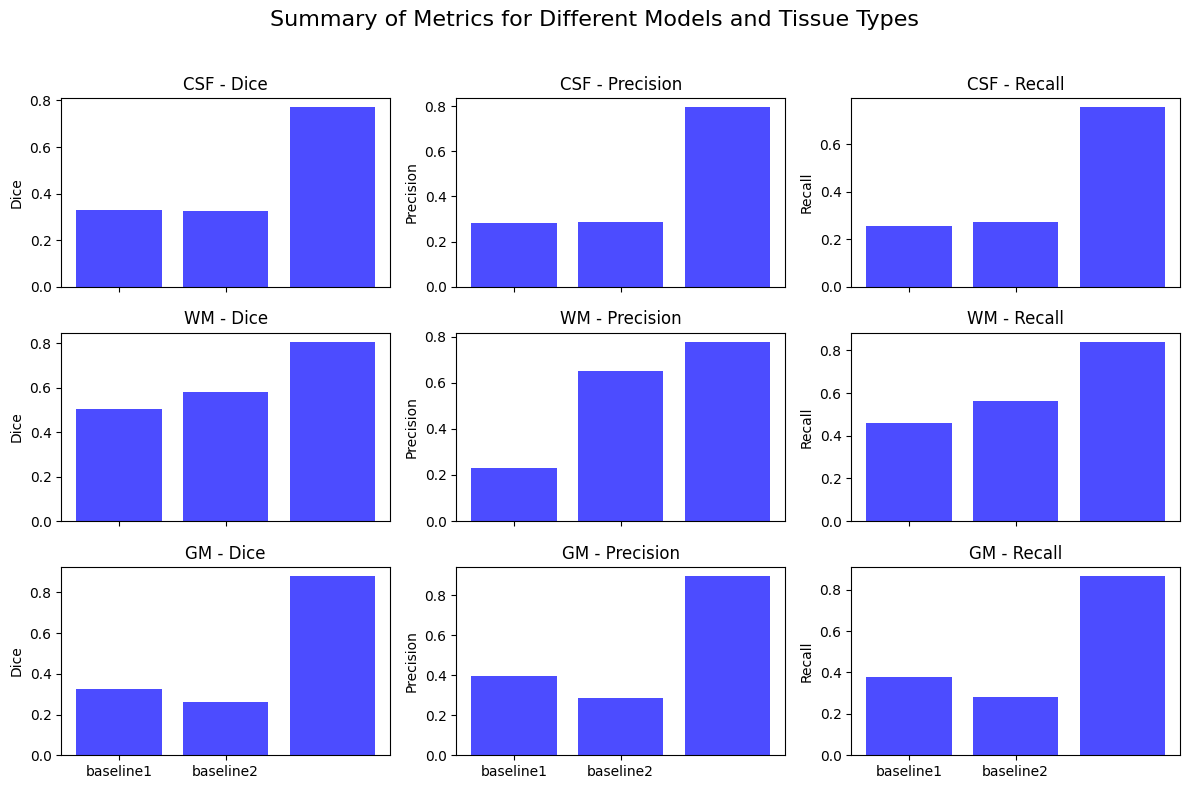

In [50]:
# Run this block after implementing Q1-3.
results_dictionary = {
    'unsupervised1': get_results_dictionary(torch.tensor(predclasses_1), torch.tensor(gt_ml)),
    'unsupervised2': get_results_dictionary(torch.tensor(predclasses_2), torch.tensor(gt_ml)),
    'u-net': get_results_dictionary(pred_seg_3,gt_test_all),
}
plot_results_summary(results_dictionary)

In [ ]:
# {'CSF': {'dice': [0.32861030868279717, 0.3269671044511859, 0.7706076282721299], 'precision': [0.2840, 0.2865 ,0.7943427562713623], 'recall': [0.2538, 0.2724 ,0.7556710243225098]}, 'WM': {'dice': [0.5031299345668412,0.5803662855404349 ,0.8071405410766601], 'precision': [0.2285,0.6494,0.7785995602607727], 'recall': [0.4576,0.5605,0.8410735130310059]}, 'GM': {'dice': [0.32618435138574403, 0.263365918200608, 0.8811058750519386], 'precision': [0.3966,0.2843 ,0.8962352871894836], 'recall': [0.3799,0.2810 ,0.8668738603591919]}}

In [ ]:
# #trial one dice loss
# import torch
# from monai.networks.nets import UNet
# from monai.losses import DiceLoss
# from monai.inferers import sliding_window_inference
# from monai.metrics import DiceMetric
# from monai.data import DataLoader, Dataset
# from monai.transforms import (Compose,Resize,ToTensor)
# transformimage = Compose([Resize(spatial_size=(64,64,64)),ToTensor()])
# transformtarget = Compose([Resize(spatial_size=(64,64,64),mode="nearest"),ToTensor()])

# # Define the 3D U-Net model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # channels=(32,64, 128, 256),
# model = UNet(
#     spatial_dims = 3,
#     in_channels = 1,
#     out_channels = 3,
#     channels=(64, 128,256,512),
#     strides = (2,2 ,2, 2),
#     ).to(device)

# # Define loss function and optimizer
# criterion = DiceLoss(sigmoid=True)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

# # Training loop
# num_epochs = 50
# # flag_train_data=1
# # flag_val_data=1
# # all_train_elements=[]
# # all_val_elements=[]

# for epoch in range(num_epochs):
#     model.train()
#     epoch_loss = 0.0
#     i_train_data=0
#     i_val_data=0

#     for inputs, targets in zip(train_files, segmentations_train):
#         inputs = torch.from_numpy(load_nii(inputs)).unsqueeze(0).to(device)
#         inputs = transformimage(inputs)

#         inputs = inputs.unsqueeze(0)
#         # print(inputs.shape)
#         plt.subplot(2,4,1)
#         plt.imshow(inputs[0][0][:,:,32].cpu(),cmap='gray')


#         outputs = model(inputs)
#         outputs = outputs.to(device)

#         if (flag_train_data):
#           csf, wm, gm, background = np.zeros((98, 116, 94)), np.zeros((98, 116, 94)), np.zeros((98, 116, 94)), np.zeros((98, 116, 94))
#           csf[targets==1] = 1
#           wm[targets==2] = 1
#           gm[targets==3] = 1
#           background[targets==0]=1
#           elements = [csf, wm, gm, background]
#           elements = torch.tensor(elements)
#           # elements = transforms(elements)
#           elements = transformtarget(elements).unsqueeze(0)
#           elements = elements.to(device)
#           all_train_elements.append(elements)

#         if (flag_train_data):
#           loss = criterion(outputs, elements)
#         else:
#           # print(all_train_elements[i_train_data].shape)
#           # # print(outputs.shape)
#           # print(np.unique(all_train_elements[i_train_data][0][0], return_counts=True))
#           # print(np.unique(all_train_elements[i_train_data][0][1], return_counts=True))
#           # print(np.unique(all_train_elements[i_train_data][0][2], return_counts=True))
#           # print(np.unique(all_train_elements[i_train_data][0][3], return_counts=True))

#           # print(np.unique(outputs, return_counts=True))
#           # break
#           if (i_train_data%30 == 0):
#             plt.subplot(2,4,2)
#             plt.imshow(all_train_elements[i_train_data][0][0][:,:,32].cpu(),cmap='gray')
#             plt.subplot(2,4,3)
#             plt.imshow(all_train_elements[i_train_data][0][1][:,:,32].cpu(),cmap='gray')
#             plt.subplot(2,4,4)
#             plt.imshow(all_train_elements[i_train_data][0][2][:,:,32].cpu(),cmap='gray')

#             # plt.subplot(2,4,5)
#             # plt.imshow(outputs[0][3][:,:,32].cpu().detach().numpy() >0, cmap='gray')
#             plt.subplot(2,4,6)
#             plt.imshow(outputs[0][0][:,:,32].cpu().detach().numpy() >0,cmap='gray')
#             plt.subplot(2,4,7)
#             plt.imshow(outputs[0][1][:,:,32].cpu().detach().numpy() >0,cmap='gray')
#             plt.subplot(2,4,8)
#             plt.imshow(outputs[0][2][:,:,32].cpu().detach().numpy() >0,cmap='gray')
#             plt.show()

#           loss = criterion(outputs, all_train_elements[i_train_data][:,:3])
#           if (i_train_data%30 == 0):
#             print(loss.item())
#           i_train_data += 1


#         epoch_loss += loss.item()
#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#     flag_train_data=0

#     # Validation
#     model.eval()
#     with torch.no_grad():
#         total_val_loss = 0.0
#         for images_val, mask_val in zip(val_files, segmentations_val):

#             images_val = torch.from_numpy(load_nii(images_val)).unsqueeze(0).to(device)
#             images_val = transformimage(images_val)
#             images_val = images_val.unsqueeze(0)

#             outputs_val = model(images_val)
#             outputs_val = outputs_val.to(device)

#             if (flag_val_data):
#               csf, wm, gm, background = np.zeros((98, 116, 94)), np.zeros((98, 116, 94)), np.zeros((98, 116, 94)), np.zeros((98, 116, 94))
#               csf[mask_val==1] = 1
#               wm[mask_val==2] = 1
#               gm[mask_val==3] = 1
#               background[mask_val==0]=1
#               elements = [csf, wm, gm, background]
#               elements = torch.tensor(elements)
#               elements = transformtarget(elements).unsqueeze(0)
#               elements = elements.to(device)
#               all_val_elements.append(elements)


#             if(flag_val_data):
#               val_loss = criterion(outputs_val, elements)
#             else:

#               if (i_val_data%25 == 0):
#                 plt.subplot(2,4,2)
#                 plt.imshow(all_val_elements[i_val_data][0][0][:,:,32].cpu(),cmap='gray')
#                 plt.subplot(2,4,3)
#                 plt.imshow(all_val_elements[i_val_data][0][1][:,:,32].cpu(),cmap='gray')
#                 plt.subplot(2,4,4)
#                 plt.imshow(all_val_elements[i_val_data][0][2][:,:,32].cpu(),cmap='gray')

#                 plt.subplot(2,4,6)
#                 plt.imshow(outputs_val[0][0][:,:,32].cpu().detach().numpy() >0,cmap='gray')
#                 plt.subplot(2,4,7)
#                 plt.imshow(outputs_val[0][1][:,:,32].cpu().detach().numpy() >0,cmap='gray')
#                 plt.subplot(2,4,8)
#                 plt.imshow(outputs_val[0][2][:,:,32].cpu().detach().numpy() >0,cmap='gray')
#                 plt.show()

#               val_loss = criterion(outputs_val, all_val_elements[i_val_data][:,:3])
#               if (i_val_data%25 == 0):
#                 print(loss.item())
#               i_val_data += 1

#             total_val_loss += val_loss.item()

#         avg_val_loss = total_val_loss / len(val_files)
#         print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss}")
#     flag_val_data=0



In [ ]:
#second trial dicefocal
import torch
from monai.networks.nets import UNet
from monai.losses import DiceLoss, DiceFocalLoss, FocalLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.data import DataLoader, Dataset
from monai.transforms import (Compose,Resize,ToTensor)
transformimage = Compose([Resize(spatial_size=(64,64,64)),ToTensor()])
transformtarget = Compose([Resize(spatial_size=(64,64,64),mode="nearest"),ToTensor()])

# Define the 3D U-Net model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims = 3,
    in_channels = 1,
    out_channels = 3,
    channels=(64, 128,256,512),
    strides = (2,2 ,2),
    ).to(device)

# Define loss function and optimizer
criterion = DiceFocalLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

# Training loop
num_epochs = 50
flag_train_data=1
flag_val_data=1
all_train_elements=[]
all_val_elements=[]

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    i_train_data=0
    i_val_data=0

    for inputs, targets in zip(train_files, segmentations_train):
        inputs = torch.from_numpy(load_nii(inputs)).unsqueeze(0).to(device)
        inputs = transformimage(inputs)

        inputs = inputs.unsqueeze(0)
        # print(inputs.shape)
        plt.subplot(2,4,1)
        plt.imshow(inputs[0][0][:,:,32].cpu(),cmap='gray')


        outputs = model(inputs)
        outputs = outputs.to(device)

        if (flag_train_data):
          csf, wm, gm, background = np.zeros((98, 116, 94)), np.zeros((98, 116, 94)), np.zeros((98, 116, 94)), np.zeros((98, 116, 94))
          csf[targets==1] = 1
          wm[targets==2] = 1
          gm[targets==3] = 1
          background[targets==0]=1
          elements = [csf, wm, gm, background]
          elements = torch.tensor(elements)
          # elements = transforms(elements)
          elements = transformtarget(elements).unsqueeze(0)
          elements = elements.to(device)
          all_train_elements.append(elements)

        if (flag_train_data):
          loss = criterion(outputs, elements)
        else:
          if (i_train_data%30 == 0):
            plt.subplot(2,4,2)
            plt.imshow(all_train_elements[i_train_data][0][0][:,:,32].cpu(),cmap='gray')
            plt.subplot(2,4,3)
            plt.imshow(all_train_elements[i_train_data][0][1][:,:,32].cpu(),cmap='gray')
            plt.subplot(2,4,4)
            plt.imshow(all_train_elements[i_train_data][0][2][:,:,32].cpu(),cmap='gray')

            plt.subplot(2,4,6)
            plt.imshow(outputs[0][0][:,:,32].cpu().detach().numpy() >0,cmap='gray')
            plt.subplot(2,4,7)
            plt.imshow(outputs[0][1][:,:,32].cpu().detach().numpy() >0,cmap='gray')
            plt.subplot(2,4,8)
            plt.imshow(outputs[0][2][:,:,32].cpu().detach().numpy() >0,cmap='gray')
            plt.show()

          loss = criterion(outputs, all_train_elements[i_train_data][:,:3])
          if (i_train_data%30 == 0):
            print(loss.item())
          i_train_data += 1


        epoch_loss += loss.item()
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    flag_train_data=0

    # Validation
    model.eval()
    with torch.no_grad():
        total_val_loss = 0.0
        for images_val, mask_val in zip(val_files, segmentations_val):

            images_val = torch.from_numpy(load_nii(images_val)).unsqueeze(0).to(device)
            images_val = transformimage(images_val)
            images_val = images_val.unsqueeze(0)

            outputs_val = model(images_val)
            outputs_val = outputs_val.to(device)

            if (flag_val_data):
              csf, wm, gm, background = np.zeros((98, 116, 94)), np.zeros((98, 116, 94)), np.zeros((98, 116, 94)), np.zeros((98, 116, 94))
              csf[mask_val==1] = 1
              wm[mask_val==2] = 1
              gm[mask_val==3] = 1
              background[mask_val==0]=1
              elements = [csf, wm, gm, background]
              elements = torch.tensor(elements)
              elements = transformtarget(elements).unsqueeze(0)
              elements = elements.to(device)
              all_val_elements.append(elements)


            if(flag_val_data):
              val_loss = criterion(outputs_val, elements)
            else:

              if (i_val_data%25 == 0):
                plt.subplot(2,4,2)
                plt.imshow(all_val_elements[i_val_data][0][0][:,:,32].cpu(),cmap='gray')
                plt.subplot(2,4,3)
                plt.imshow(all_val_elements[i_val_data][0][1][:,:,32].cpu(),cmap='gray')
                plt.subplot(2,4,4)
                plt.imshow(all_val_elements[i_val_data][0][2][:,:,32].cpu(),cmap='gray')

                plt.subplot(2,4,6)
                plt.imshow(outputs_val[0][0][:,:,32].cpu().detach().numpy() >0,cmap='gray')
                plt.subplot(2,4,7)
                plt.imshow(outputs_val[0][1][:,:,32].cpu().detach().numpy() >0,cmap='gray')
                plt.subplot(2,4,8)
                plt.imshow(outputs_val[0][2][:,:,32].cpu().detach().numpy() >0,cmap='gray')
                plt.show()

              val_loss = criterion(outputs_val, all_val_elements[i_val_data][:,:3])
              if (i_val_data%25 == 0):
                print(loss.item())
              i_val_data += 1

            total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_files)
        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss}")
    flag_val_data=0